# Using the Bootstrap to estimate uncertainty

Unike traditional confidence intervals the bootstrap method makes no distributional assumptions about the underlying data. As such using the bootstrap is at the very least a nice additional dimension to add on top of any analysis. In the best case the bootstrap can provide more sensical results than a traditional CI ever could (think negative durations or distances). It can also be narrower! Finally the bootsrap is easy to implement and can be used to calcualte the uncertainty of virtually any statistic: mins, maxes, percentiles, OLS paratmeter estimates... the list is endless. For these reasons being familiar and comfortable using the bootstrap is a great position for any data scientist to be in.

In [58]:
###
# Code and examples of how to use the bootstrap in a myriad of different settings
# Date: Fall 2022
# Author Alex Parker
###

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

sns.set_theme(context = 'notebook', style = 'whitegrid')

In [59]:
### Set the renderer to 'svg' or 'png' for static images (visible in github) or 'vscode' for interactive (not viisble in github)
plotly_renderer = 'svg'
#plotly_renderer = 'vscode'

if plotly_renderer in ['svg','png']:
    print("You've chosen static images for plotly data visualizations, these should display in github")
elif plotly_renderer == 'vscode':
    print("You've chosen vscode for the ploltly renderer, these images will not display in github but will be animated in a VScode notebook environment")
else:
     print("please choose an appropriate plotly image renderer")

You've chosen static images for plotly data visualizations, these should display in github


## Dataset Creation: Simulating a randomized experiment with user defined treatment effects

In [60]:
np.random.seed(4567)
n = 10000

### Generate Some Fake Data
age = pd.Series(np.random.randint(low = 18, high = 72, size = n), name = 'age', dtype = 'int64')
gender = pd.Series(np.random.choice(a = ['male','female','other'], size = n, p = [.49,.48,.03]), name = 'gender', dtype = 'category')
married = pd.Series(np.random.choice(a = [True,False], size = n, p = [.4,.6]), name = 'married', dtype = 'boolean')
treatment = pd.Series(np.random.choice(a = ['control','treatment1','treatment2'], size = n, p = [.333,.333,.334]), name = 'treatment', dtype = 'category')

data = pd.concat([age ,gender ,married ,treatment], axis = 1)

# Generate target variable and amke dependant upon Age
data['spend'] = 14 + .5*data.age*np.random.chisquare(df = 5, size =n)

# Generate treatment effects (in percent terms)
real_effect_1 = .05
real_effect_2 = .08 

treatment1 = data.loc[data['treatment']=='treatment1', 'spend']
treatment1 = treatment1*np.random.normal(loc = 1 + real_effect_1,scale = .15, size =len(treatment1))

treatment2 = data.loc[data['treatment']=='treatment2', 'spend']
treatment2 = treatment2*np.random.normal(loc = 1 + real_effect_2, scale = .2, size =len(treatment2))

data.loc[data['treatment']=='treatment1','spend'] = treatment1
data.loc[data['treatment']=='treatment2','spend'] = treatment2

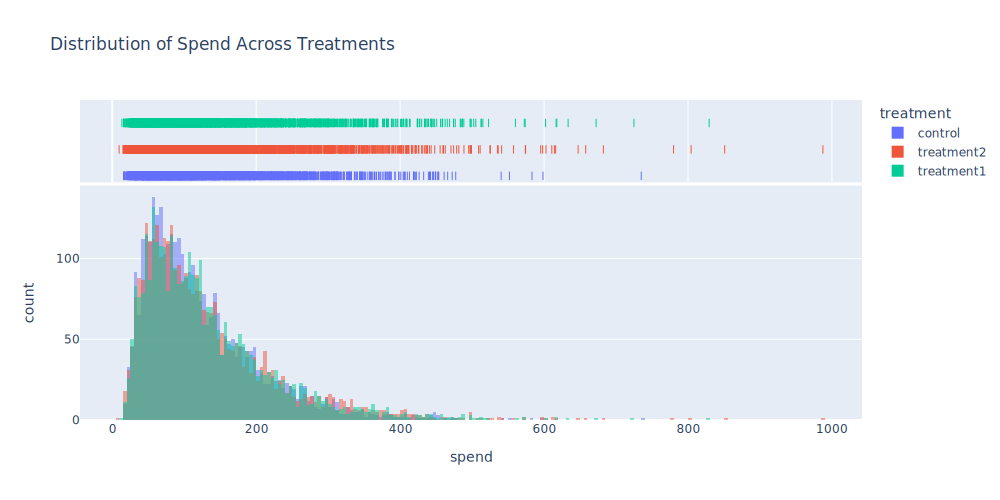

In [61]:
fig = px.histogram(data, 
    x = 'spend', 
    color = 'treatment',
    marginal = 'rug',
    title = 'Distribution of Spend Across Treatments',
    opacity= .50)
fig.update_layout(barmode = 'overlay', height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

## Bootrapped Estimates of the Effect Size Using the Difference of Means

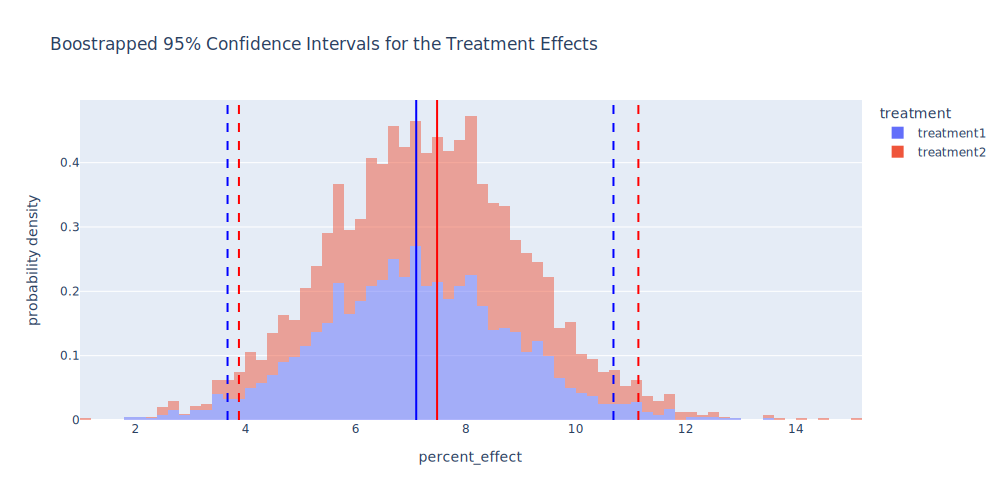

In [62]:
### Bootstrapped confidence interval for the percent effect between treatments and control
ols_boot_1 = []
ols_boot_2 = []
n = 2000

for i in range(n):
    boot_sample = data.sample(frac = 1, replace = True)
    boot_mean = boot_sample.groupby('treatment', as_index = False)['spend'].mean()
    treat1_eff = (boot_mean.iloc[1,1] - boot_mean.iloc[0,1]) / boot_mean.iloc[0,1] * 100
    treat2_eff = (boot_mean.iloc[2,1] - boot_mean.iloc[0,1]) / boot_mean.iloc[0,1] * 100
    ols_boot_1.append(treat1_eff)
    ols_boot_2.append(treat2_eff)

ols_boot_1 = pd.DataFrame(ols_boot_1, columns = ['percent_effect']).assign(treatment = 'treatment1')
ols_boot_2 = pd.DataFrame(ols_boot_2, columns = ['percent_effect']).assign(treatment = 'treatment2')
boots = pd.concat([ols_boot_1, ols_boot_2], axis = 0)

#%%

fig = px.histogram(boots, 
    x = 'percent_effect', 
    color = 'treatment', 
    opacity= .5, 
    histnorm = 'probability density',
    title = 'Boostrapped 95% Confidence Intervals for the Treatment Effects' )
fig.add_vline(x = ols_boot_1.percent_effect.mean(), line_color = 'blue')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.975), line_color = 'blue', line_dash = 'dash')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.025), line_color = 'blue', line_dash = 'dash')

fig.add_vline(x = ols_boot_2.percent_effect.mean(), line_color = 'red')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.975), line_color = 'red', line_dash = 'dash')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.025), line_color = 'red', line_dash = 'dash')

fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

### How accurate are the difference of mean estimates?

In [75]:
real_effects = pd.DataFrame([['treatment1',real_effect_1*100],['treatment2',real_effect_2*100]], columns = ['treatment','real_effect'])

boots_gp = boots.groupby('treatment', as_index = False).agg(
        ci_lower = ('percent_effect', lambda x: x.quantile(.05)),
        mean = ('percent_effect', 'mean'),
        ci_upper = ('percent_effect', lambda x: x.quantile(.95)))

boots_gp = boots_gp.merge(real_effects, how = 'inner', on = 'treatment')
boots_gp['difference'] = boots_gp['mean'] - boots_gp['real_effect']
boots_gp

,treatment,ci_lower,mean,ci_upper,real_effect,difference
0,treatment1,4.284564,7.105301,9.950443,5.0,2.105301
1,treatment2,4.449020,7.484235,10.511253,8.0,-0.515765


## Using the Bootsrap with OLS: Are the results more accurate after including controls?

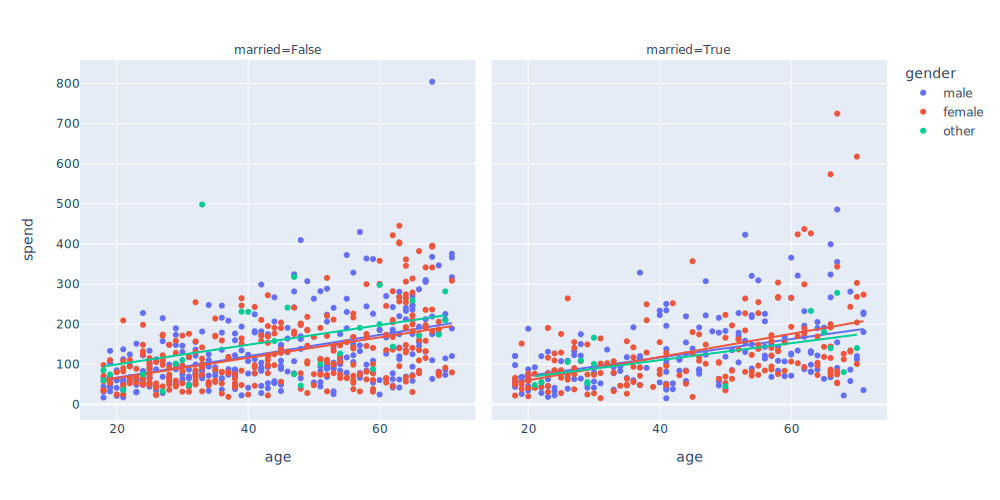

In [64]:
### Pre Regression plots to inform the OLS model

fig = px.scatter(data.sample(n = 1000), 
    x = 'age', 
    y = 'spend', 
    color = 'gender',
    facet_col = 'married', 
    trendline = 'ols')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

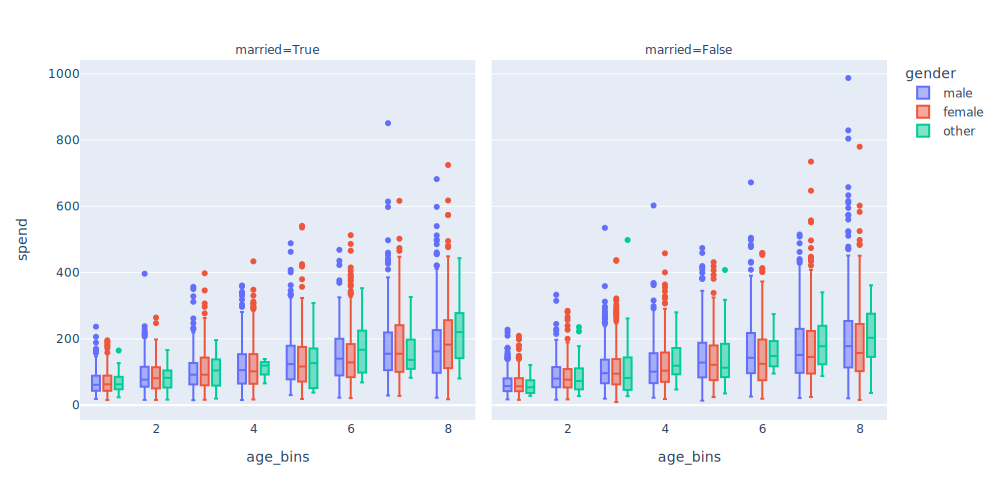

In [65]:
data['age_bins'] = pd.cut(data.age, bins = 8, labels = [1,2,3,4,5,6,7,8])
fig = px.box(data, x = 'age_bins', y = 'spend', color = 'gender', facet_col = 'married')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

In [66]:
# Run an OLS model
model = smf.ols('np.log(spend) ~ treatment', data=data)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(spend)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.163
Date:                Tue, 18 Oct 2022   Prob (F-statistic):            0.00211
Time:                        23:40:23   Log-Likelihood:                -10045.
No. Observations:               10000   AIC:                         2.010e+04
Df Residuals:                    9997   BIC:                         2.012e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.6281      0.011    406.829      0.000       4.606       4.650
treatment[T.treatment1]     0.0538      0.016      3.325      0.001       0.022       0.086
treatment[T.treatment2]     0.0424      0.016      2.626      0.009       0.011       0.074
==============================================================================
Omnibus:                       79.396   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.417
Skew:                          -0.066   Prob(JB):                     5.61e-13
Kurtosis:                       2.656   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
###Boostrapped confidence interval for OLS models
ols_boot_1 = []
ols_boot_2 = []
ols_boot_age = []

n = 2000

for i in range(n):
    boot_data = data.sample(frac = 1, replace = True)
    boot_model = smf.ols('np.log(spend) ~  treatment', data=boot_data).fit()
    treat1_eff = boot_model.params[1]*100
    treat2_eff = boot_model.params[2]*100
    #age_eff = boot_model.params[3]*100
    ols_boot_1.append(treat1_eff)
    ols_boot_2.append(treat2_eff)
    #ols_boot_age.append(age_eff)

ols_boot_1 = pd.DataFrame(ols_boot_1, columns = ['percent_effect']).assign(param = 'treatment1')
ols_boot_2 = pd.DataFrame(ols_boot_2, columns = ['percent_effect']).assign(param = 'treatment2')
#ols_boot_age = pd.DataFrame(ols_boot_age, columns = ['percent_effect']).assign(param = 'age')
ols_boots = pd.concat([ols_boot_1,ols_boot_2], axis = 0) #,ols_boot_age], axis = 0)


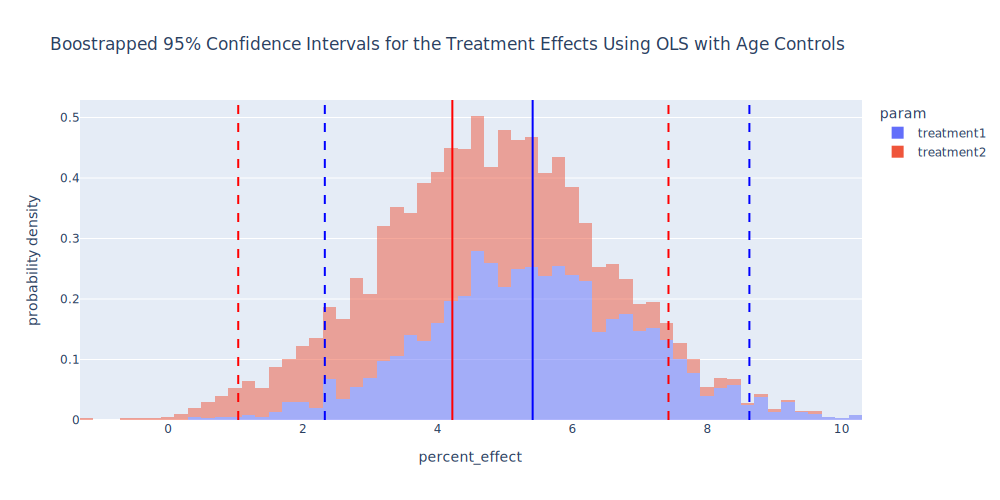

In [68]:

### PLotting the results of the OLS Boostrap
fig = px.histogram(ols_boots.query("not param =='age'"), 
    x = 'percent_effect', 
    color = 'param', 
    opacity= .5, 
    histnorm = 'probability density',
    title = 'Boostrapped 95% Confidence Intervals for the Treatment Effects Using OLS with Age Controls' )
fig.add_vline(x = ols_boot_1.percent_effect.mean(), line_color = 'blue')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.975), line_color = 'blue', line_dash = 'dash')
fig.add_vline(x = ols_boot_1.percent_effect.quantile(.025), line_color = 'blue', line_dash = 'dash')

fig.add_vline(x = ols_boot_2.percent_effect.mean(), line_color = 'red')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.975), line_color = 'red', line_dash = 'dash')
fig.add_vline(x = ols_boot_2.percent_effect.quantile(.025), line_color = 'red', line_dash = 'dash')
fig.update_layout(height = 500, width = 1000)
fig.show(renderer = plotly_renderer)

In [73]:
ols_boots_gp = ols_boots.groupby('param', as_index = False).agg(
        ci_lower = ('percent_effect', lambda x: x.quantile(.05)),
        mean = ('percent_effect', 'mean'),
        ci_upper = ('percent_effect', lambda x: x.quantile(.95)))

ols_boots_gp = ols_boots_gp.merge(real_effects, how = 'inner', left_on = 'param', right_on = 'treatment')
ols_boots_gp['difference'] = ols_boots_gp['mean'] - ols_boots_gp['real_effect']


## Which is more accurate?

#### Difference of Means:

In [70]:
boots_gp

,treatment,ci_lower,mean,ci_upper,real_effect,difference
0,treatment1,3.679214,7.105301,10.687021,5.0,2.105301
1,treatment2,3.885966,7.484235,11.139310,8.0,-0.515765


#### OLS with Age controls:

In [74]:
ols_boots_gp

,param,ci_lower,mean,ci_upper,treatment,real_effect,difference
0,treatment1,2.767933,5.414498,8.110042,treatment1,5.0,0.414498
1,treatment2,1.480909,4.223298,6.818412,treatment2,8.0,-3.776702


## Using the Bootsrap for the Median

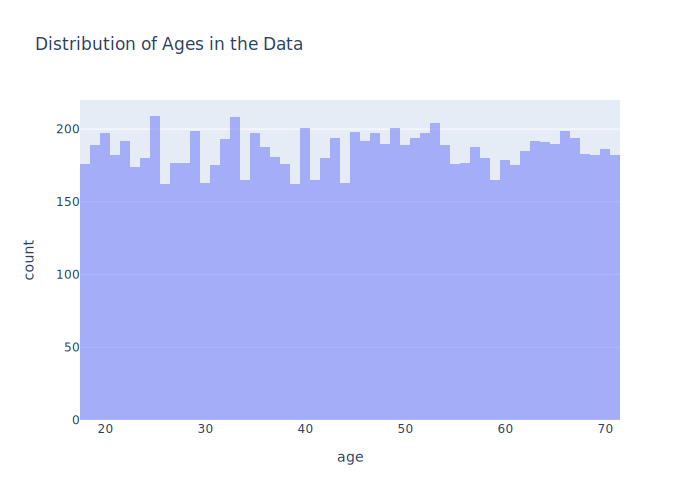

The median age in the data is: 45.0


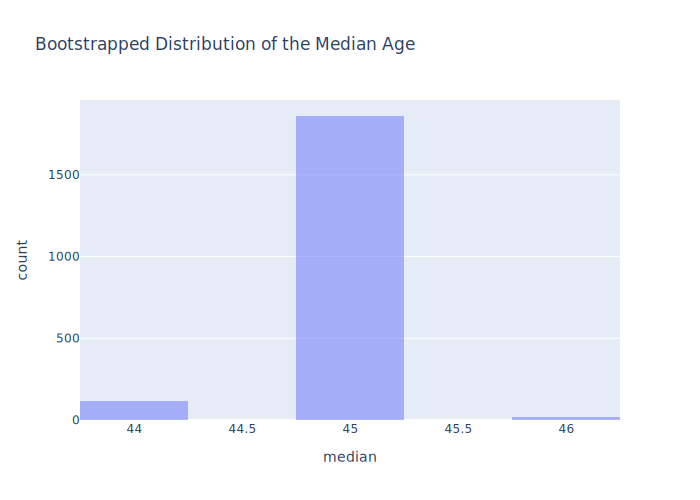

In [72]:


### Boostrapped confidence interval for the median 

fig = px.histogram(data, 
    x = 'age', 
    opacity = .5, 
    title = "Distribution of Ages in the Data")
fig.show(renderer = plotly_renderer)

print("The median age in the data is:", data.age.median())

boot_med = []
n = 2000

for i in range(n):
    boot_sample = data['age'].sample(frac = 1, replace = True)
    boot_median = boot_sample.median()
    boot_med.append(boot_median)

boot_med = pd.DataFrame(boot_med, columns= ['median'])

fig = px.histogram(boot_med, 
    x = 'median', 
    opacity = .5,
    title = "Bootstrapped Distribution of the Median Age")
fig.show(renderer = plotly_renderer)

